In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [623]:
isem_2021_o=pd.read_excel("./part2.xlsx",sheet_name="2021",parse_dates=True)
isem_2020_o=pd.read_excel("./part2.xlsx",sheet_name="2020",parse_dates=True)
isem_2019_o=pd.read_excel("./part2.xlsx",sheet_name="2019",parse_dates=True)

In [769]:
isem_2021 = isem_2021_o
isem_2020 = isem_2020_o
isem_2019 = isem_2019_o

In [770]:
def create_isem_df(data):
    isem_data = data
    isem_data.columns = isem_data.iloc[1]
    isem_data = isem_data.iloc[2:]
    isem_data = isem_data.iloc[:,1:21].reset_index(drop=True)
    isem_prices = isem_data.iloc[:,[1,3,4,5,6,7,10]].reset_index(drop=True).fillna(0)
    isem_demand = isem_data.iloc[:,11:].reset_index(drop=True).fillna(0)
    isem_prices_col = ["trade_date","DAM","IDA1","IDA2","IDA3","BM","Cal_date"]
    isem_demand_col = ["Day_Wind","Cont_Wind","Output_Wind",
                       "Day_Demand","Cont_Demand","Output_Demand",
                       "Day_NetDemand","Cont_NetDemand","Output_NetDemand"]
    isem_prices.columns=isem_prices_col
    isem_demand.columns=isem_demand_col

    cols = list(isem_prices.columns)
    cols = [cols[-1]] + cols[:-1]
    isem_prices = isem_prices[cols]
    isem_prices

    isem_prices = isem_prices.infer_objects()
    isem_demand = isem_demand.infer_objects()
    isem_prices['trade_date'] = pd.to_datetime(isem_prices['trade_date'], format = '%d/%m/%Y')

    isem_complete= pd.concat([isem_prices, isem_demand], axis=1, ignore_index=False)
    return (isem_complete)

In [656]:
def check_for_na(data):
    na_info = data.isna().values.any()
    if na_info:
        print("NA found")
    else:
        print(f"No NA found")
        

In [657]:
isem_complete_2019 = create_isem_df(isem_2019)
isem_complete_2020 = create_isem_df(isem_2020)
isem_complete_2021 = create_isem_df(isem_2021)

In [658]:
# Verified there is no NA data in the complete data frame

check_for_na(isem_complete_2019)
check_for_na(isem_complete_2020)
check_for_na(isem_complete_2021)

No NA found
No NA found
No NA found


In [771]:
def plot_isemprices(data,title):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.DAM,label="DAM")
    plt.plot(data.Cal_date,data.IDA1,label="IDA1")
    plt.plot(data.Cal_date,data.IDA2,label="IDA2")
    plt.plot(data.Cal_date,data.IDA3,label="IDA3")
    plt.plot(data.Cal_date,data.BM,"--",color="grey",label="BM")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title,fontsize=17)
    plt.grid()
        
def plot_windforecast(data):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.Day_Wind,label="Day_Wind",color="silver")
    plt.plot(data.Cal_date,data.Cont_Wind,"--",label="Cont_Wind",color="black")
    plt.plot(data.Cal_date,data.Output_Wind,label="Output_Wind", color="black")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
def plot_netdemandforecast(data):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.Day_NetDemand,label="Day_NetDemand",color="darkred")
    plt.plot(data.Cal_date,data.Cont_NetDemand,"--",label="Cont_NetDemand",color="darkred")
    plt.plot(data.Cal_date,data.Output_NetDemand,label="Output_NetDemand", color="salmon")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
def plot_data_compare(data,title):
    plot_isemprices(data,title)
    plot_windforecast(data)
    plot_netdemandforecast(data)

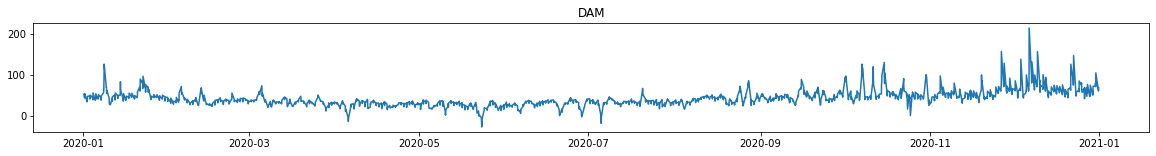

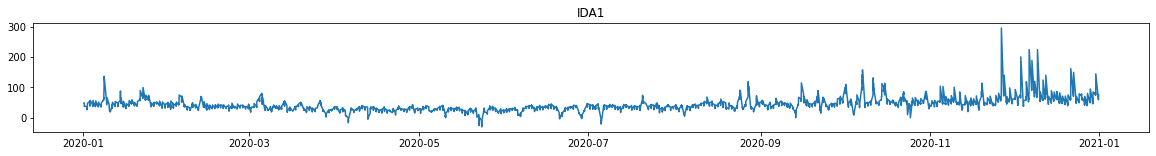

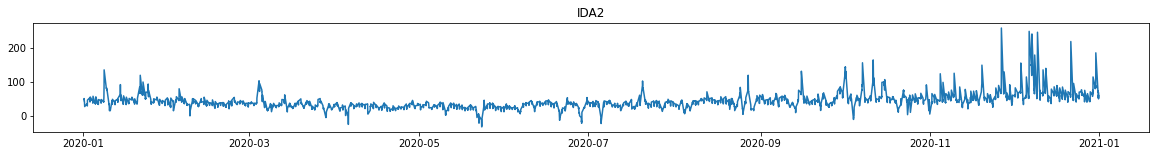

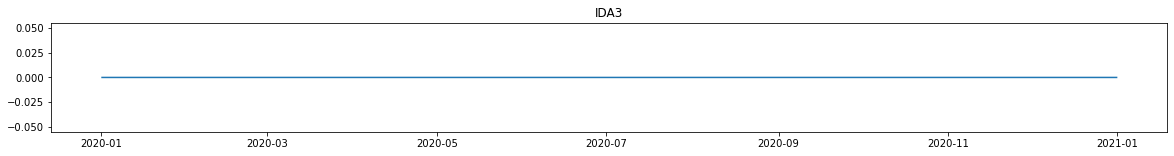

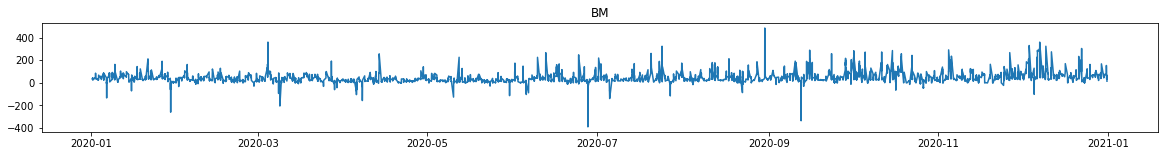

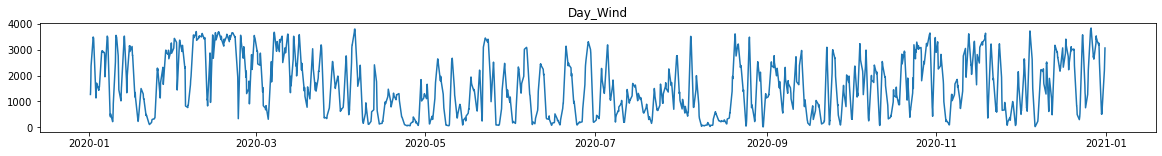

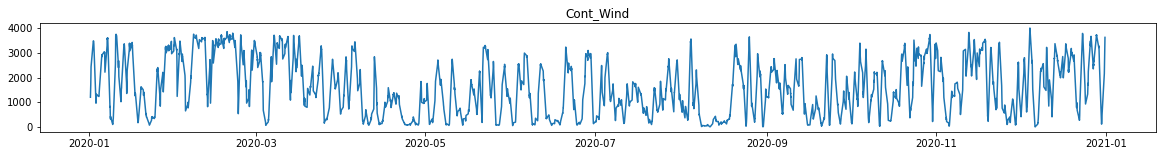

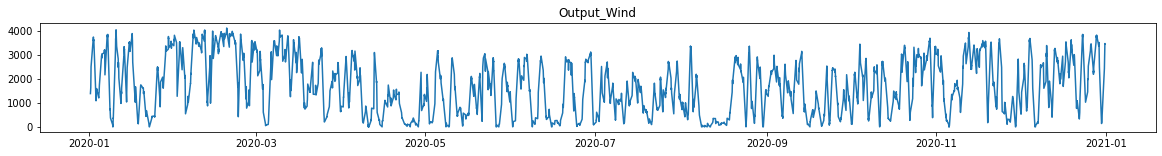

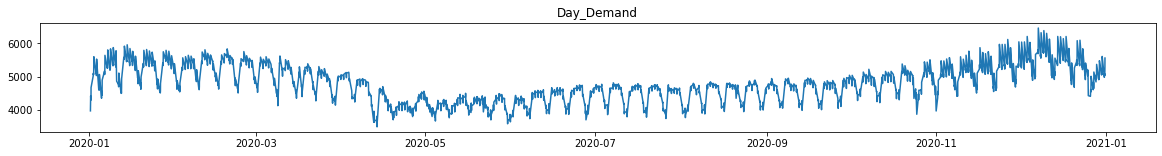

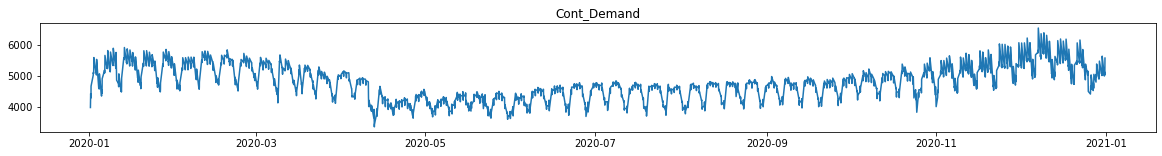

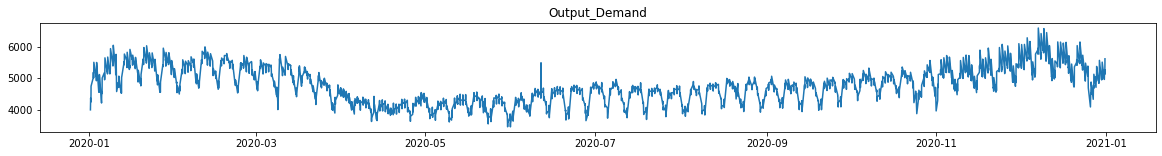

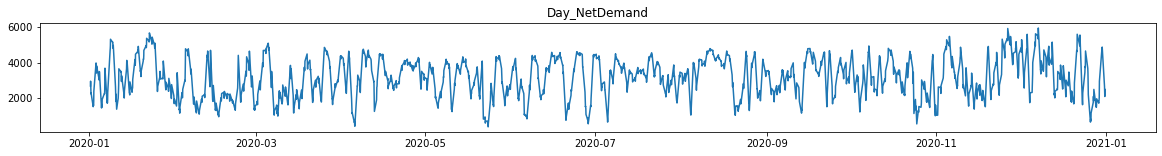

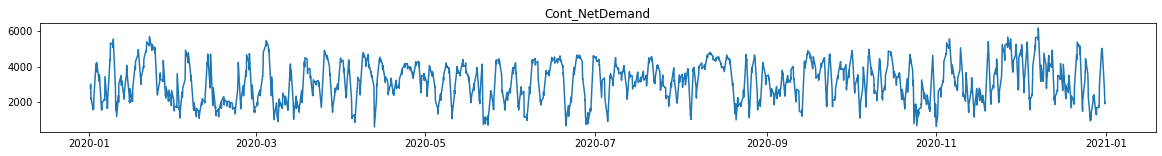

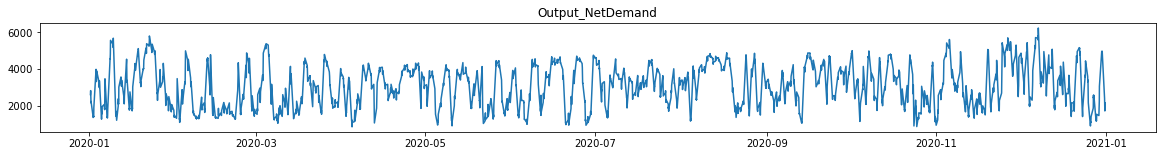

In [629]:
colums_set = isem_complete.columns

data = isem_complete[(isem_complete["IDA2"] != 0) & (isem_complete["IDA3"] == 0)]
for i in range(2,len(colums_set)):
    plt.figure(figsize=(20,2))
    plt.plot(data.Cal_date, data.iloc[:,i])
    plt.title(colums_set[i])

In [774]:
### Trade 1 - Market 1
def trade_mark1(row):
    if ((row["IDA2"] == 0) &
        (row["IDA3"] == 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["BM"] - row["DAM"])
    else:
        return (0)

### Trade 1 - Market 2
def trade_mark2(row):
    if ((row["IDA2"] > 0) &
        (row["IDA3"] == 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["BM"] - row["IDA1"])
    else:
        return (row["PL"])
    
### Trade 1 - Market 3
def trade_mark3(row):
    if ((row["IDA2"] > 0) &
        (row["IDA3"] > 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["DAM"] - row["IDA3"])
    else:
        return (row["PL"])

def prepare_market(data):
    market_1 = data[(data["IDA2"] == 0) &
                         (data["IDA3"] == 0)]
    market_2 = data[(data["IDA2"] > 0) &
                             (data["IDA3"] == 0)]
    market_3 = data[(data["IDA2"] > 0) &
                             (data["IDA3"] > 0)]
    print(f"Dimensions of market 1 {market_1.shape}")
    print(f"Dimensions of market 2 {market_2.shape}")
    print(f"Dimensions of market 3 {market_3.shape}")
    Trade = data
    Trade['PL'] = Trade.apply(lambda row : trade_mark1(row), axis = 1)
    print(Trade[Trade['PL'] >0].shape)
    print(max(Trade['PL']))
    print(Trade[Trade['PL'] <0].shape)
    print(min(Trade['PL']))
    print(Trade['PL'].sum())
    Trade['PL'] = Trade.apply(lambda row : trade_mark2(row), axis = 1)
    print(Trade[Trade['PL'] >0].shape)
    print(max(Trade['PL']))
    print(Trade[Trade['PL'] <0].shape)
    print(min(Trade['PL']))
    print(Trade['PL'].sum())
    Trade['PL'] = Trade.apply(lambda row : trade_mark3(row), axis = 1)
    print(Trade[Trade['PL'] >0].shape)
    print(max(Trade['PL']))
    print(Trade[Trade['PL'] <0].shape)
    print(min(Trade['PL']))
    print(Trade['PL'].sum())
    return (Trade,market_1,market_2,market_3)

In [775]:
Trade_2019,M1_2019,M2_2019,M3_2019 = prepare_market(isem_complete_2019)
Trade_2020,M1_2020,M2_2020,M3_2020 = prepare_market(isem_complete_2020)
Trade_2021,M1_2021,M2_2021,M3_2021 = prepare_market(isem_complete_2021)

pl_data_2019 = pd.DataFrame([np.arange(0,Trade_2019['PL'].shape[0]), Trade_2019['PL'], np.cumsum(Trade_2019['PL'])]).T
pl_data_2019.columns=["Iter","PL","PL_cum"]

pl_data_2020 = pd.DataFrame([np.arange(0,Trade_2020['PL'].shape[0]), Trade_2020['PL'], np.cumsum(Trade_2020['PL'])]).T
pl_data_2020.columns=["Iter","PL","PL_cum"]

pl_data_2021 = pd.DataFrame([np.arange(0,Trade_2021['PL'].shape[0]), Trade_2021['PL'], np.cumsum(Trade_2021['PL'])]).T
pl_data_2021.columns=["Iter","PL","PL_cum"]

Dimensions of market 1 (8760, 17)
Dimensions of market 2 (4382, 17)
Dimensions of market 3 (4361, 17)
(1329, 17)
368.853
(2614, 17)
-311.04999999999995
-1479.3130000000037
(1989, 17)
368.853
(3827, 17)
-311.04999999999995
-457.33300000000213
(2864, 17)
368.853
(4777, 17)
-311.04999999999995
-7096.0850000000055
Dimensions of market 1 (8793, 17)
Dimensions of market 2 (4325, 17)
Dimensions of market 3 (4314, 17)
(1442, 17)
349.31
(2011, 17)
-224.60999999999999
10895.976999999999
(2136, 17)
421.8399999999999
(2821, 17)
-224.60999999999999
25136.240999999998
(2915, 17)
421.8399999999999
(3651, 17)
-224.60999999999999
19427.726000000002
Dimensions of market 1 (4958, 17)
Dimensions of market 2 (2454, 17)
Dimensions of market 3 (2457, 17)
(1083, 17)
348.7399999999999
(1500, 17)
-336.72999999999996
4459.830000000004
(1732, 17)
1091.05
(2061, 17)
-336.72999999999996
26007.920000000006
(2499, 17)
1091.05
(2460, 17)
-336.72999999999996
36215.781


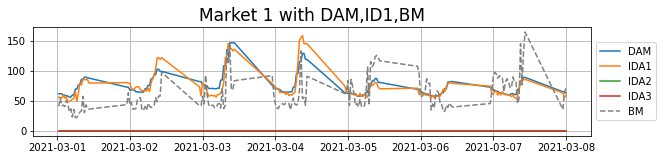

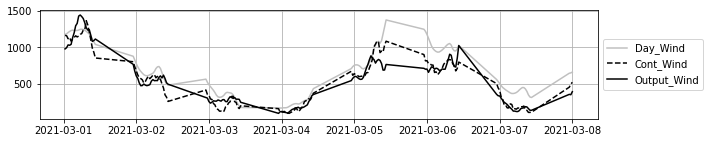

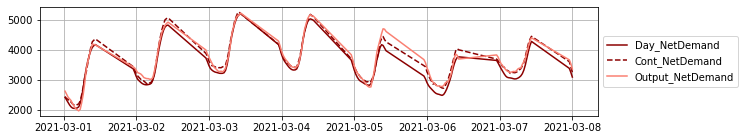

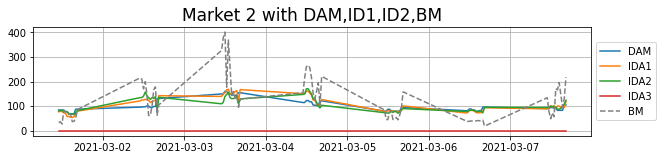

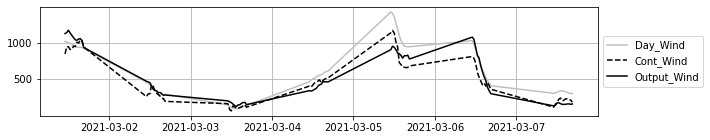

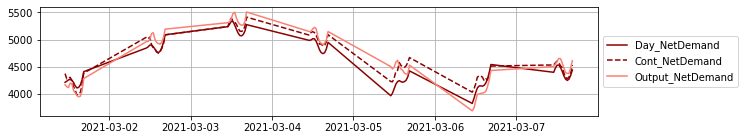

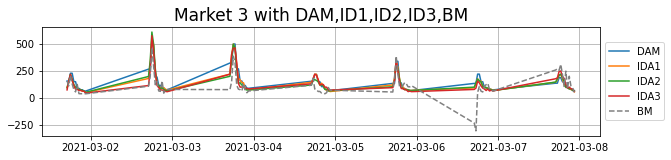

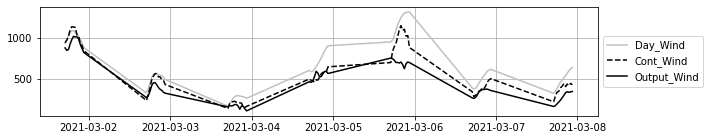

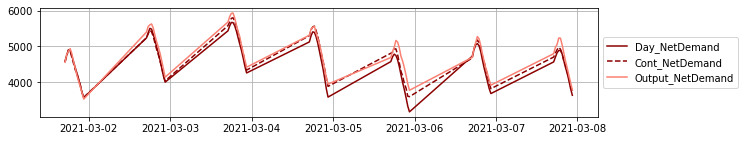

In [768]:
M1_2021_inspect = M1_2021[(M1_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M1_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

M2_2021_inspect = M2_2021[(M2_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M2_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

M3_2021_inspect = M3_2021[(M3_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M3_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

plot_data_compare(M1_2021_inspect,"Market 1 with DAM,ID1,BM")
plot_data_compare(M2_2021_inspect,"Market 2 with DAM,ID1,ID2,BM")
plot_data_compare(M3_2021_inspect,"Market 3 with DAM,ID1,ID2,ID3,BM")


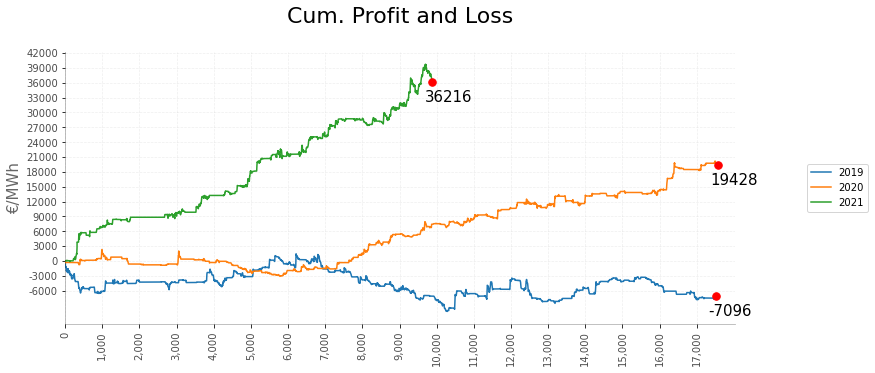

In [780]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(12,5))
plt.plot(pl_data_2019.Iter, pl_data_2019.PL_cum,label="2019")
plt.plot(pl_data_2020.Iter, pl_data_2020.PL_cum,label="2020")
plt.plot(pl_data_2021.Iter, pl_data_2021.PL_cum,label="2021")
plt.plot(pl_data_2019['Iter'].iloc[-1], pl_data_2019['PL_cum'].iloc[-1],"r.",markersize=15)
plt.plot(pl_data_2020['Iter'].iloc[-1], pl_data_2020['PL_cum'].iloc[-1],"r.",markersize=15)
plt.plot(pl_data_2021['Iter'].iloc[-1], pl_data_2021['PL_cum'].iloc[-1],"r.",markersize=15)
plt.text(pl_data_2019['Iter'].iloc[-1]-200, pl_data_2019['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2019['PL_cum'].iloc[-1])}",fontsize=15)
plt.text(pl_data_2020['Iter'].iloc[-1]-200, pl_data_2020['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2020['PL_cum'].iloc[-1])}",fontsize=15)
plt.text(pl_data_2021['Iter'].iloc[-1]-200, pl_data_2021['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2021['PL_cum'].iloc[-1])}",fontsize=15)
plt.xlim(0,pl_data_2019.shape[0]+500)
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)
plt.ylabel('€/MWh',fontsize=15,alpha=.6)
xtick_location = pl_data_2019.Iter.tolist()[::1000]
xtick_labels = pl_data_2019.Iter.tolist()[::1000]
ytick_location = np.arange(-6000,45000,3000)
ytick_labels = np.arange(-6000,45000,3000)
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, alpha=.7)
plt.yticks(ticks=ytick_location, labels=ytick_labels,alpha=.7)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Cum. Profit and Loss\n", fontsize=22)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7,alpha=0.2)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7,alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))



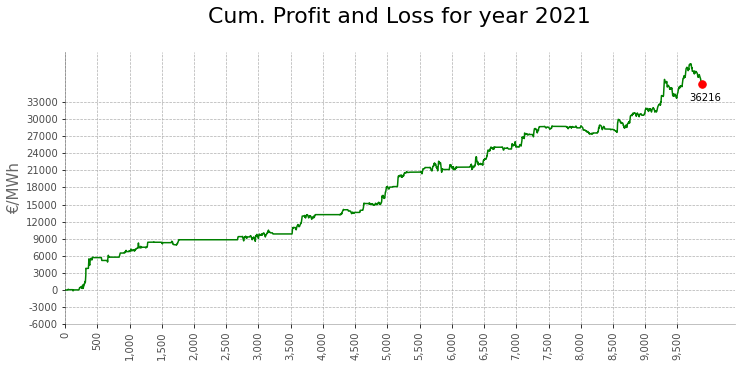

In [782]:
plt.figure(figsize=(12,5))
plt.plot(pl_data_2021.Iter, pl_data_2021.PL_cum,label="2021",color="green")
plt.plot(pl_data_2021['Iter'].iloc[-1], pl_data_2021['PL_cum'].iloc[-1],"r.",markersize=15)
plt.text(pl_data_2021['Iter'].iloc[-1]-200, pl_data_2021['PL_cum'].iloc[-1]-3000,f"{round(pl_data_2021['PL_cum'].iloc[-1])}")
plt.xlim(0,pl_data_2021.shape[0]+500)
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)
plt.ylabel('€/MWh',fontsize=15,alpha=.6)
xtick_location = pl_data_2021.Iter.tolist()[::500]
xtick_labels = pl_data_2021.Iter.tolist()[::500]
ytick_location = np.arange(-6000,35000,3000)
ytick_labels = np.arange(-6000,35000,3000)
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, alpha=.7)
plt.yticks(ticks=ytick_location, labels=ytick_labels,alpha=.7)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Cum. Profit and Loss for year 2021\n", fontsize=22)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7)


In [783]:
def show_pl_calc(data,year):
    print("\n***********************************")
    print(f"Profit Loss data for year {year}")
    print("***********************************")
    total_trades = sum(data.PL != 0)
    total_avail_trades =  data.shape[0]
    per_trades = round((total_trades/total_avail_trades)*100,2)
    win_trade = sum(data.PL > 0)
    loss_trade = sum(data.PL < 0)
    win_ratio = round((win_trade/(win_trade+loss_trade)*100),2)
    loss_ratio = round((loss_trade/(win_trade+loss_trade)*100),2)
    av_win_trade = round(np.mean(data[data["PL"] > 0]["PL"]),2)
    av_loss_trade = round(np.mean(data[data["PL"] < 0]["PL"]),2)
    max_win_trade = np.max(data[data["PL"] > 0]["PL"])
    max_loss_trade = round(np.min(data[data["PL"] < 0]["PL"]),2)
    print(f"Total trades: {total_trades}")
    print(f"Total Available trades: {total_avail_trades}")
    print(f"Percentage of trades: {per_trades}%")
    print("------------------------------------")
    print(f"Winning trades: {win_trade}")
    print(f"Loss trades: {loss_trade}")
    print("------------------------------------")
    print(f"Winning Ratio: {win_ratio}%")
    print(f"Loss Ratio: {loss_ratio}%")
    print("------------------------------------")
    print(f"Average Win trades: {av_win_trade}")
    print(f"Average Loss trades: {av_loss_trade}")
    print("------------------------------------")
    print(f"Max Win trades: {max_win_trade}")
    print(f"Max Loss trades: {max_loss_trade}")

In [784]:
show_pl_calc(pl_data_2019,"2019")
show_pl_calc(pl_data_2020,"2020")
show_pl_calc(pl_data_2021,"2021")


***********************************
Profit Loss data for year 2019
***********************************
Total trades: 7641
Total Available trades: 17520
Percentage of trades: 43.61%
------------------------------------
Winning trades: 2864
Loss trades: 4777
------------------------------------
Winning Ratio: 37.48%
Loss Ratio: 62.52%
------------------------------------
Average Win trades: 33.69
Average Loss trades: -21.69
------------------------------------
Max Win trades: 368.853
Max Loss trades: -311.05

***********************************
Profit Loss data for year 2020
***********************************
Total trades: 6566
Total Available trades: 17568
Percentage of trades: 37.37%
------------------------------------
Winning trades: 2915
Loss trades: 3651
------------------------------------
Winning Ratio: 44.4%
Loss Ratio: 55.6%
------------------------------------
Average Win trades: 27.97
Average Loss trades: -17.01
------------------------------------
Max Win trades: 421.83999